In [2]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## GluonTS datasets

In [3]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['exchange_rate', 'solar-energy', 'electricity', 'traffic', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly']


An available dataset can be easily downloaded by its name. In this notebook we will use the "m4_hourly" dataset that contains a few hundred time series. If the dataset already exists locally it is not downloaded again by setting regenerate=False.


In [5]:
dataset = get_dataset("m4_hourly", regenerate=False)

INFO:root:using dataset already processed in path m4_hourly.


In general, the datasets provided by GluonTS are objects that consists of three main components:

dataset.train is an iterable collection of data entries used for training.
dataset.test is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
dataset.metadata containts metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.


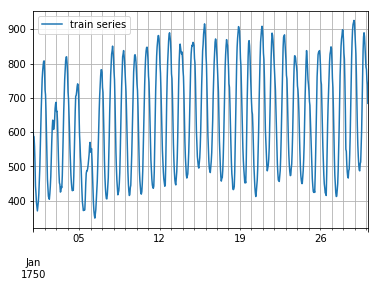

In [6]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

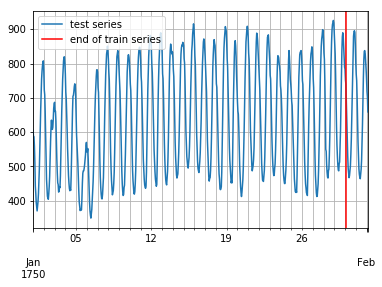

In [7]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [8]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.time_granularity}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## Custom datasets

At this point, it is important to emphasize that GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a numpy.array and the index of the time series in a pandas.Timestamp (possibly different for each time series):

In [9]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq='1H')  # can be different for each time series

In [20]:
custom_dataset

array([[-3.05153857e-01, -2.51762475e-01,  2.47165590e-01,
        -1.87812433e+00,  2.24590941e+00,  1.79807124e+00,
         9.61656111e-01, -1.14911194e+00, -1.29286541e-01,
        -4.69212109e-02,  4.65016087e-02, -2.10687881e+00,
         4.54715778e-01, -1.34927594e+00, -1.37158371e-01,
         1.74776184e-02,  7.90954035e-01, -4.78446475e-01,
         4.70295406e-01,  7.88935111e-01, -7.64148774e-01,
         7.86408869e-01, -2.33106289e+00, -3.76865274e-01,
         1.56148947e+00,  3.70423647e-01, -2.05177987e+00,
         4.09853692e-01, -1.04788887e+00,  1.48358571e+00,
         3.67181672e-01, -4.05105193e-01, -5.48091099e-01,
         1.06514058e+00,  2.00180548e-02, -3.14272369e-01,
        -7.94082507e-01, -3.07442583e-02,  7.54074760e-02,
         2.35426129e+00,  6.06447880e-01, -6.05306166e-01,
         3.39124221e-01,  5.20721103e-01, -2.48079837e+00,
        -1.49399012e+00, -9.54428342e-01, -2.15005973e-01,
         1.94412713e+00, -7.10456598e-01, -3.00742575e-0

In [9]:
dataset.train

Now, you can split your dataset and bring it in a GluonTS appropriate format with just two lines of code:

In [11]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = [{'target': x, 'start': start} for x in custom_dataset[:, :-prediction_length]]
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = [{'target': x, 'start': start} for x in custom_dataset]

## Training an existing model (Estimator)

As we already mentioned, GluonTS comes with a number of pre-built models that can be used directly with minor hyperparameter configurations. For starters we will use one of these predefined models to go through the whole pipeline of training a model, predicting, and evaluating the results.

GluonTS gives focus (but is not restricted) to probabilistic forecasting, i.e., forecasting the future distribution of the values and not the future values themselves (point estimates) of a time series. Having estimated the future distribution of each time step in the forecasting horizon, we can draw a sample from the distribution at each time step and thus create a "sample path" that can be seen as a possible realization of the future. In practice we draw multiple samples and create multiple sample paths which can be used for visualization, evaluation of the model, to derive statistics, etc.

In this example we will use a simple pre-built feedforward neural network estimator that takes as input a window of length context_length and predicts the distribution of the values of the subsequent future window of length prediction_length.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the prediction_length) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a Trainer, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [12]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

In [13]:
estimator1 = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.time_granularity,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1E-3, hybridize=True, num_batches_per_epoch=200,),
)


In [35]:
estimator2 = DeepAREstimator(prediction_length=dataset.metadata.prediction_length, 
                             context_length=100,
                             freq=dataset.metadata.time_granularity, 
                             trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1E-3, 
                                             hybridize=True, num_batches_per_epoch=200,))

After specifing our estimator with all the necessary hyperparameters we can train it using our training dataset dataset.train just by invoking the train method of the estimator. The training returns a predictor that can be used to predict.

In [36]:
predictor = estimator1.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 483
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 169.55it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[0] Elapsed time 1.182 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.149096
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 154.69it/s, avg_epoch_loss=4.74]
INFO:root:Epoch[1] Elapsed time 1.294 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.740127
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 174.72it/s, avg_epoch_loss=4.63]
INFO:root:Epoch[2] Elapsed time 1.148 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.631756
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 165.84it/s, avg_epoch_loss=4.53]
INFO:root:Epoch[3] Elapsed time 1.214 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.526570
INFO:root:Epoch[4] Le

In [37]:
predictor2 = estimator2.train(training_data=dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:26<00:00,  7.49it/s, avg_epoch_loss=4.33]
INFO:root:Epoch[0] Elapsed time 26.689 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.325216
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:26<00:00,  7.64it/s, avg_epoch_loss=3.84]
INFO:root:Epoch[1] Elapsed time 26.188 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.840050
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:26<00:00,  7.65it/s, avg_epoch_loss=3.71]
INFO:root:Epoch[2] Elapsed time 26.160 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.709724
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:26<00:00,  7.52it/s, avg_epoch_loss=3.66]
INFO:root:Epoch[3] Elapsed time 26.603 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.658039
INFO:root:Epoch[4] Learning ra

Now we have a predictor in our hands. We can use it to predict the last window of the dataset.test and evaluate how our model performs.

GluonTS comes with the make_evaluation_predictions function that automates all this procedure. Roughly, this module performs the following steps:

Removes the final window of length prediction_length of the dataset.test that we want to predict
The estimator uses the remaining dataset to predict (in the form of sample paths) the "future" window that was just removed
The module outputs a generator over the forecasted sample paths and a generator over the dataset.test

In [50]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [51]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor2,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

In [52]:
print(type(forecast_it))
print(type(ts_it))

<class 'generator'>
<class 'generator'>


First, we can convert these generators to lists to ease the subsequent computations.

In [53]:
forecasts = list(forecast_it)
tss = list(ts_it)

Now, let's see what do these lists contain under the hood. Let's start with the time series tss that is simpler. Each item in the tss list is just a pandas dataframe that contains the actual time series.

In [54]:
print(type(tss[0]))

<class 'pandas.core.frame.DataFrame'>


In [1]:
tss[0].head()  

NameError: name 'tss' is not defined

The forecasts list is a bit more complex. Each item in the forecasts list is an object that contains all the sample paths in the form of numpy.ndarray with dimension (num_samples, prediction_length), the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [56]:
print(type(forecasts[0]))
print(len(forecasts))

<class 'gluonts.model.forecast.SampleForecast'>
414


In [57]:
print(f"Number of sample paths: {forecasts[0].num_samples}")
print(f"Dimension of samples: {forecasts[0].samples.shape}")
print(f"Start date of the forecast window: {forecasts[0].start_date}")
print(f"Frequency of the time series: {forecasts[0].freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


Apart from retrieving basic information we can do some more complex calculations such as to compute the mean or a given quantile of the values of the forecasted window.

In [58]:
print(f"Mean of the future window:\n {forecasts[0].mean}")
print(f"0.5-quantile (median) of the future window:\n {forecasts[0].quantile(0.5)}")
print(f"0.1-quantile of the future window:\n {forecasts[0].quantile(0.1)}")
print(f"0.9-quantile (median) of the future window:\n {forecasts[0].quantile(0.9)}")

Mean of the future window:
 [638.26624 572.7423  524.9944  504.3805  485.67538 478.7146  486.07605
 503.06207 522.53735 553.666   620.3211  711.7492  774.2428  831.7981
 859.7419  860.0313  842.40344 840.4581  814.5728  794.2612  776.8576
 727.5044  701.5687  649.30646 576.75793 522.31537 494.34332 479.81097
 453.485   447.6377  451.3754  475.71524 498.3473  541.86255 599.07556
 644.3523  717.8028  753.33984 765.2706  744.2807  744.6802  761.3473
 749.0246  738.6158  687.63635 659.3797  621.4257  570.66797]
0.5-quantile (median) of the future window:
 [635.6688  580.0005  526.14465 496.46008 488.10062 484.14624 482.4866
 501.46112 523.51526 558.9191  617.31964 701.0881  772.1588  830.52844
 860.4025  872.6859  874.29254 834.1853  799.07434 783.68286 743.6937
 708.74365 700.0208  640.83203 565.40826 517.0313  486.14313 469.56223
 450.40424 445.22363 439.38303 473.80344 499.84586 538.34503 584.7919
 654.6208  706.32495 754.60333 766.73425 759.77106 754.74927 752.256
 738.231   726.5572  

Finally, each forecast object has a plot method that can be parametrized to show the mean, prediction intervals, etc. The prediction intervals are plotted in different shades so they are distinct.

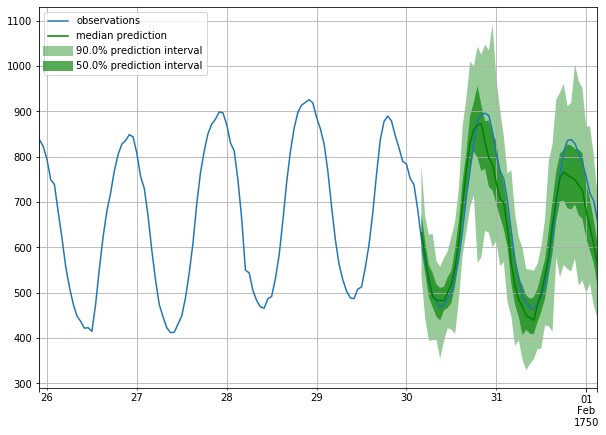

In [59]:
plot_length = 150 
prediction_intervals = (50.0, 90.0)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
tss[0][-plot_length:].plot(ax=ax)  # plot the time series
forecasts[0].plot(prediction_intervals=prediction_intervals, color='g')
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

We can also evaluate the quality of our forecasts. GluonTS comes with an Evaluator that returns aggregate error metrics as well as metrics per time series which can be used e.g., for scatter plots.

In [60]:
from gluonts.evaluation import Evaluator

In [61]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation:   0%|          | 0/414 [00:00<?, ?it/s]/Users/benjamin/anaconda3/envs/Python36/lib/python3.6/site-packages/gluonts/evaluation/_base.py:170: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  ts = time_series[: forecast.start_date - 1]
Running evaluation: 100%|██████████| 414/414 [00:02<00:00, 199.45it/s]


In [62]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 36056350.65758549,
    "abs_error": 15665082.00373745,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 3.3783429979465742,
    "sMAPE": 0.16268345673147702,
    "MSIS": 30.92736105250971,
    "QuantileLoss[0.1]": 4714794.324723339,
    "Coverage[0.1]": 0.028079710144927536,
    "QuantileLoss[0.5]": 15665081.989639282,
    "Coverage[0.5]": 0.18614130434782608,
    "QuantileLoss[0.9]": 16827043.406744767,
    "Coverage[0.9]": 0.6863929146537842,
    "RMSE": 6004.6940519551445,
    "NRMSE": 0.8197733703711935,
    "ND": 0.107620254901327,
    "wQuantileLoss[0.1]": 0.0323909805842699,
    "wQuantileLoss[0.5]": 0.10762025480447157,
    "wQuantileLoss[0.9]": 0.11560301441368168,
    "mean_wQuantileLoss": 0.08520474993414105,
    "MAE_Coverage": 0.1997953569511541
}


In [65]:
item_metrics.head()

,Coverage[0.1],Coverage[0.5],Coverage[0.9],MASE,MSE,MSIS,QuantileLoss[0.1],QuantileLoss[0.5],QuantileLoss[0.9],abs_error,abs_target_mean,abs_target_sum,item_id,sMAPE,seasonal_error
0,0.0000,0.395833,1.000000,0.966279,2159.980794,4.922357,1164.301147,1965.239929,837.938916,1965.239990,659.250000,31644.0,NaN,0.060664,42.371302
1,0.0625,0.750000,0.958333,1.134710,48006.791667,4.822955,3157.133960,8992.782593,3709.117432,8992.782227,2586.437500,124149.0,NaN,0.068387,165.107988
2,0.0000,0.062500,0.479167,2.724013,83572.677083,57.166576,3712.942688,10314.949463,9514.080676,10314.949219,1354.791667,65030.0,NaN,0.160898,78.889053
3,0.0000,0.250000,0.416667,2.180527,514253.666667,44.939017,8409.227441,27106.457275,24964.964941,27106.457031,4912.145833,235783.0,NaN,0.118214,258.982249
4,0.0000,0.083333,0.583333,1.744518,176466.937500,15.229684,7203.867236,16788.743774,6261.987158,16788.744141,2731.000000,131088.0,NaN,0.136967,200.494083


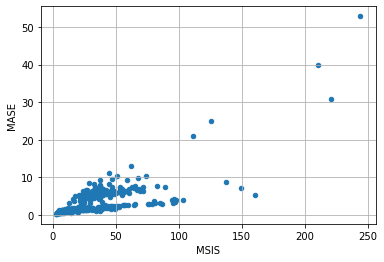

In [66]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()